In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from time import gmtime, strftime

In [2]:
import glob

cur_path = "/kaggle/input/mafaulda-machinery-fault-database/"

normal_file_names = glob.glob(cur_path + 'normal/*.csv',recursive=True)
imnormal_file_names_6g = glob.glob(cur_path + 'imbalance/6g/*.csv',recursive=True)

all_files = normal_file_names + imnormal_file_names_6g

columns_names = ['Tachometer'
                 ,'Underhang bearing accelerometer axial'
                 ,'Underhang bearing accelerometer radiale'
                 ,'Underhang bearing accelerometer tangential'
                 ,'Overhang bearing accelerometer axial'
                 ,'Overhang bearing accelerometer radiale'
                 ,'Overhang bearing accelerometer tangential'
                 ,'Microphone']

#all_files

In [3]:
def readFiles(path_names):
    data = {}
    report_step = 30
    report_iter = 0
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()),'Start Processing Files...')
    for i in path_names:
        if ((report_iter % report_step) == 0):
            print(strftime("%Y-%m-%d %H:%M:%S", gmtime()),'Processing file number',report_iter,i)
        low_data = pd.read_csv(i,header=None)
        data[i] = low_data
        report_iter += 1
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()),'Finished processing files!!')
    return data

data_raw = readFiles(all_files)

2021-07-29 11:23:06 Start Processing Files...
2021-07-29 11:23:06 Processing file number 0 /kaggle/input/mafaulda-machinery-fault-database/normal/45.4656.csv
2021-07-29 11:23:22 Processing file number 30 /kaggle/input/mafaulda-machinery-fault-database/normal/13.1072.csv
2021-07-29 11:23:37 Processing file number 60 /kaggle/input/mafaulda-machinery-fault-database/imbalance/6g/31.5392.csv
2021-07-29 11:23:53 Processing file number 90 /kaggle/input/mafaulda-machinery-fault-database/imbalance/6g/27.648.csv
2021-07-29 11:23:57 Finished processing files!!


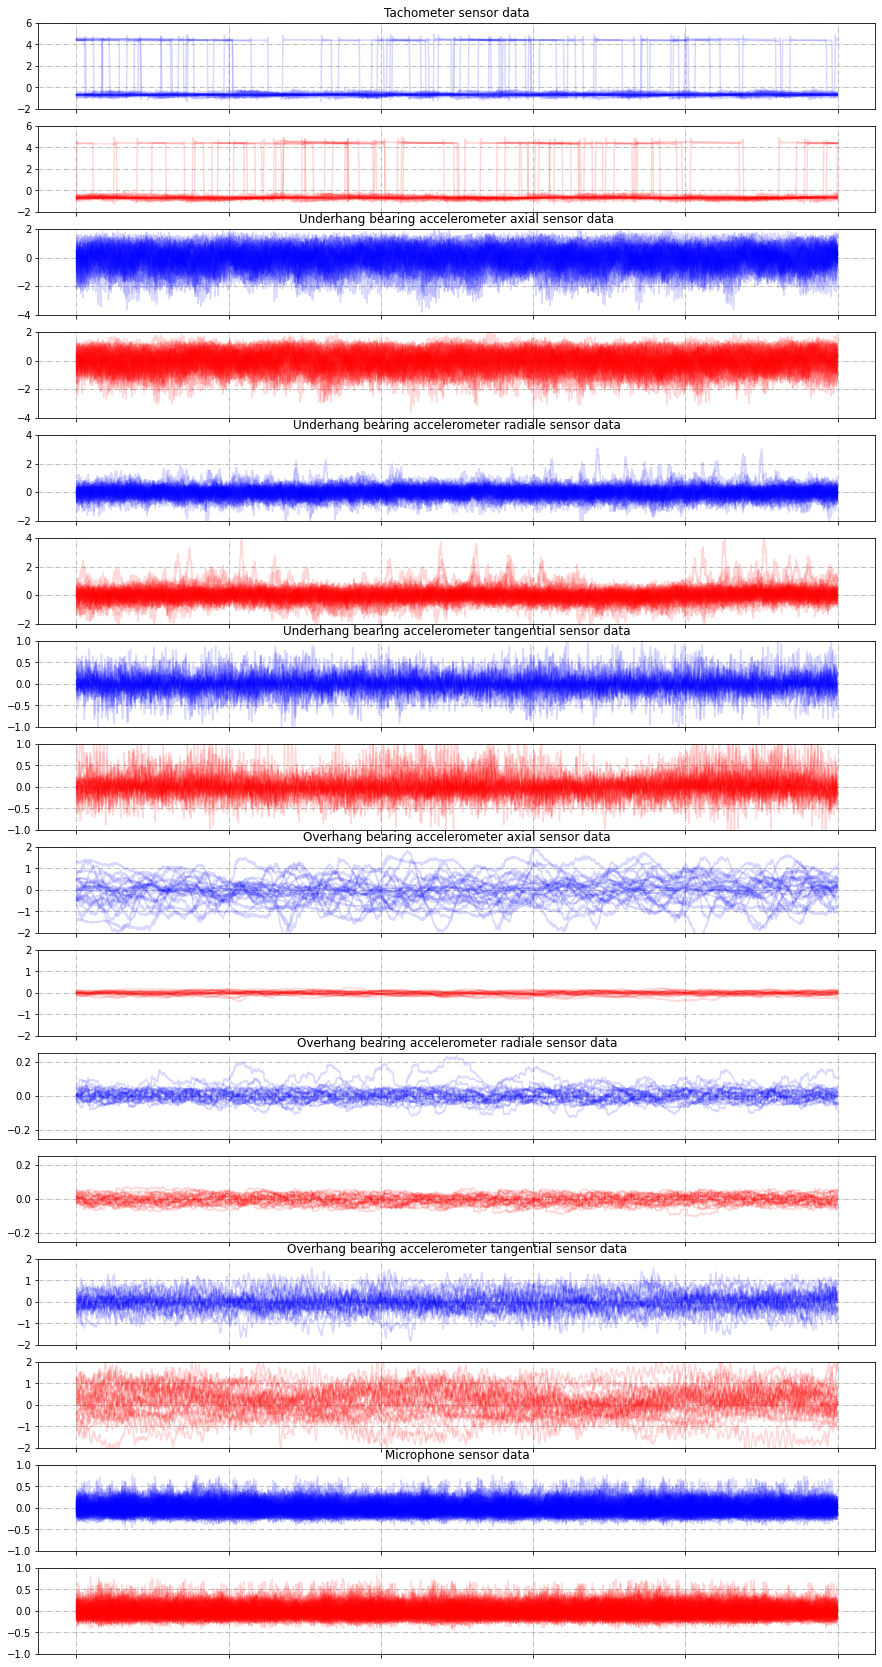

In [4]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(16, sharex=False, sharey=False,figsize=(15,30))
#fig.suptitle('All Features of Normal\Imbalance State')
limits = [[-2,6]
        ,[-4,2]
        ,[-2,4]
        ,[-1,1]
        ,[-2,2]
        ,[-0.25,0.25]
        ,[-2,2]
        ,[-1,1]]
number_of_samples_to_show = 2500
number_of_sequences_to_show = 25
transparency = 0.15
for i in range(8):
    for j in range(number_of_sequences_to_show):
        axs[i*2].plot(data_raw[normal_file_names[j]][i][0:number_of_samples_to_show]
                      ,alpha = transparency,color = 'b')
        axs[i*2].get_xaxis().set_ticklabels([])
        axs[i*2].set_ylim(limits[i])
        axs[i*2].grid(True,linestyle="-.")
        
        axs[i*2+1].plot(data_raw[imnormal_file_names_6g[j]][i][0:number_of_samples_to_show]
                        ,alpha = transparency,color = 'r')
        axs[i*2+1].get_xaxis().set_ticklabels([])
        axs[i*2+1].set_ylim(limits[i])
        axs[i*2+1].grid(True, linestyle="-.")
    axs[i*2].set_title('{} sensor data'.format(columns_names[i]))

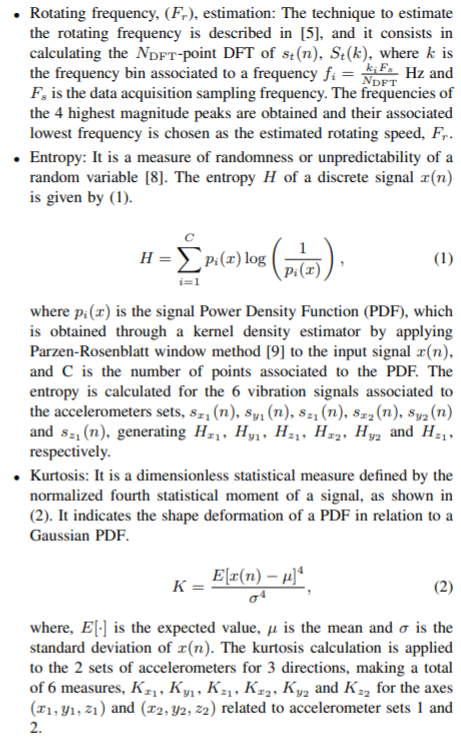

In [5]:
from scipy import fft,stats
from sklearn.neighbors import KernelDensity

def calculateEntropy(data,filePath,_debug =False,bandwidth = 0.1, mode = 'decimal'):
    data_min = int(data.min()-1)
    data_max = int(data.max()+2)
    if(_debug):
        print('------'*10)
        print('File:',filePath)
        print('Min:',data_min,'Max:',data_max)
        print('Creating Kernel...')
    kde_model = KernelDensity(bandwidth = bandwidth, kernel='gaussian')
    kde_model.fit(data.values.reshape(-1, 1))
    if(_debug):
        print('Kernel fitted!')
    if (mode == 'integer'):
        samples_data = np.array(range(data_min-2,data_max+2))
        factor = 1
    else:
        step = (data_max - data_min) * 10 + 1 
        samples_data = np.linspace(data_min,data_max,step)
        factor = 10
    if(_debug):
        print('Getting Probabilities...')
    log_probabilities = kde_model.score_samples(samples_data.reshape((len(samples_data), 1)))
    probabilities = np.exp(log_probabilities)/factor
    if(_debug):
        print('Probabilities calculated!!',probabilities)
    entropy = 0
    for p in probabilities[probabilities >= 1e-10 ]:
        entropy += p*np.log(1/p)
    
    if(_debug):
        print(samples_data)
        print('Entropy is',entropy,'and total probability is',probabilities.sum())
        fig, ax = plt.subplots(constrained_layout=True)
        ax.plot(samples_data[:], probabilities, color='r')
        ax2 = ax.twinx()
        ax2.hist(data.values, bins=50, density=True, label = 'histogram')
        plt.show()
    return entropy

def calculateMetricsAlzghoul(data,filePath, SAMPLE_RATE = 50000, DURATION = 5, _debug = False):

    mean = data.mean()
    entropy = calculateEntropy(data,filePath,_debug)
    kurtosis = stats.kurtosis(data)
    if(_debug):
        print('Mean',mean)
        print('Kustosis',kurtosis)
        print('------'*10)
        print()
        print()
    #plt.figure(figsize=(15,5))
    #plt.plot(xf, np.abs(yf))
    #plt.xlim(0,1000)
    #plt.xticks(range(0,1000,50))
    #plt.show()
    return [mean, entropy ,kurtosis]

def calculateMainFrequency(data,filePath, SAMPLE_RATE = 50000, DURATION = 5, _debug = False):
    # Normal Sequences
    # There are 49 sequences without any fault, 
    # each with a fixed rotation speed within the range from 737 rpm to 3686 
    # rpm with steps of approximately 60 rpm.

    # Number of samples
    N = SAMPLE_RATE * DURATION
    
    if(_debug):
        print('------'*10)
        print('File:',filePath)
    yf = fft.rfft(data.values)
    xf = fft.rfftfreq(N, 1/SAMPLE_RATE)
    freq = xf[np.argpartition(np.abs(yf), -4)[-4:]].min()
    if(_debug):
        print('Frequency is',freq, 'in hertz and', freq*60,'in RPM',)
        print('------'*10)
        print()
        print()
    #plt.figure(figsize=(15,5))
    #plt.plot(xf, np.abs(yf))
    #plt.xlim(0,1000)
    #plt.xticks(range(0,1000,50))
    #plt.show()
    return freq

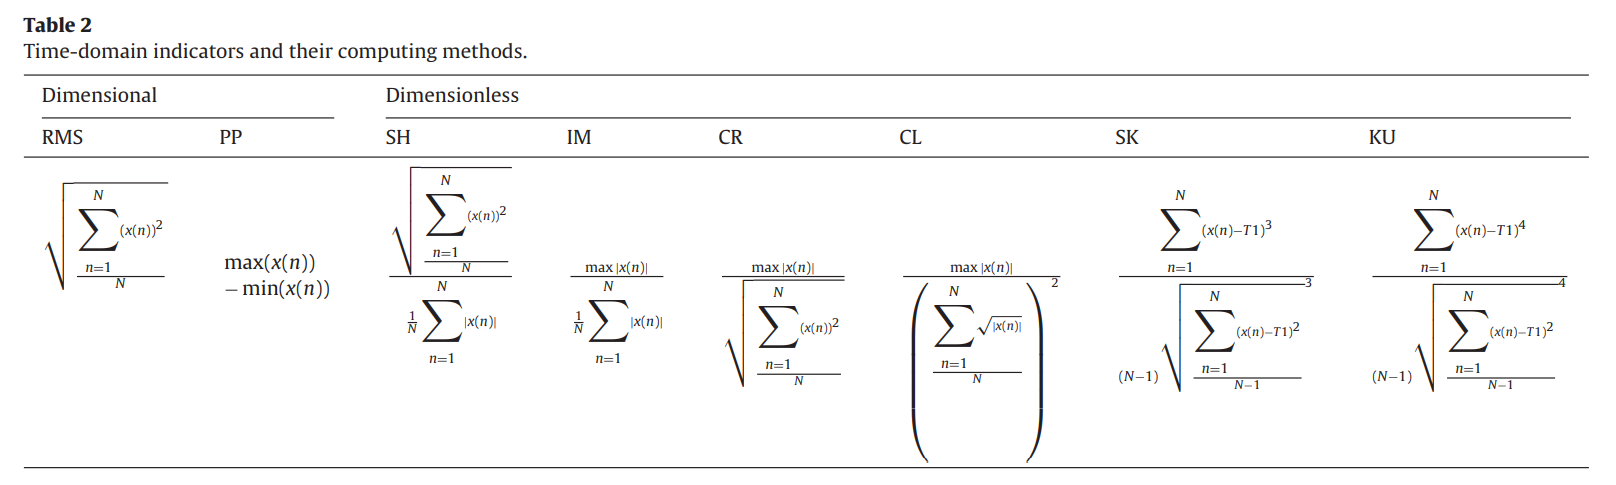

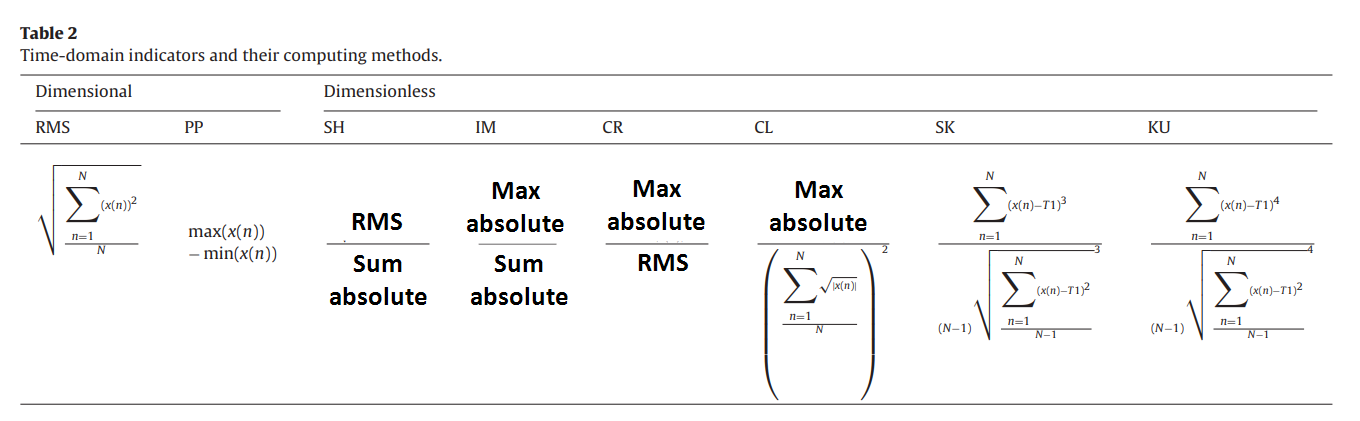

In [6]:
def calculateMetricsDongyang(data, filePath, _debug = False):
    N = len(data)
    rms = np.sqrt(np.sum(data**2)/N)
    peak_peak = data.min() - data.max()
    sum_abs = (1/N)*np.sum(np.abs(data))
    shape_indicator = rms / sum_abs
    max_abs = np.max(np.abs(data))
    impulse_indicator = max_abs / sum_abs
    crest_indicator = max_abs/rms
    clearance_indicator = max_abs/(np.sum(np.sqrt(np.abs(data)))/N)**2
    skewness = stats.skew(data)
    if(_debug):
        print('------'*10)
        print('File:',filePath)
        print('Root Mean Square is',rms)
        print('Peak-peak is',peak_peak)
        print('Shape Indicator is',shape_indicator)
        print('Impulse Indicator is',impulse_indicator)
        print('Crest Indicator is',crest_indicator)
        print('Clearance Indicator is',clearance_indicator)
        print('skewness is',skewness)
        print('------'*10)
        print()
        print()
    return [rms,peak_peak,shape_indicator,impulse_indicator,crest_indicator,clearance_indicator,skewness]

------------------------------------------------------------
File: /kaggle/input/mafaulda-machinery-fault-database/normal/45.4656.csv
Min: -2 Max: 6
Creating Kernel...
Kernel fitted!
Getting Probabilities...
Probabilities calculated!! [6.76031524e-12 6.53926831e-10 2.42515438e-08 3.58094592e-07
 2.29421779e-06 7.96762996e-06 2.93178392e-05 2.03429977e-04
 1.40446030e-03 7.01028140e-03 2.54458390e-02 7.59028444e-02
 1.81502239e-01 2.58317009e-01 1.86960335e-01 8.15349029e-02
 3.08733996e-02 1.04717008e-02 2.70618364e-03 5.28499195e-04
 1.04011901e-04 4.48511088e-05 4.38757923e-05 5.18256368e-05
 5.67324041e-05 5.92832907e-05 5.56304668e-05 4.87724907e-05
 4.18677431e-05 3.53825154e-05 3.35344131e-05 3.16094842e-05
 2.87994501e-05 2.78543053e-05 3.20694931e-05 3.63369515e-05
 3.24697089e-05 3.13052037e-05 3.84147492e-05 4.03622547e-05
 3.73827077e-05 3.64473361e-05 3.44267582e-05 3.30287403e-05
 3.62872596e-05 3.97728424e-05 4.39651966e-05 4.66602491e-05
 4.30826228e-05 3.68886983e-05 3.

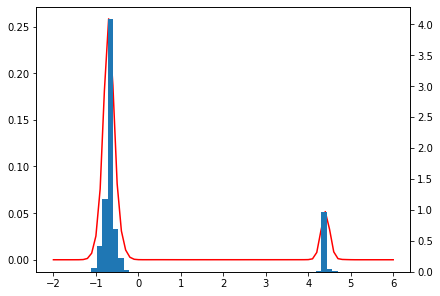

------------------------------------------------------------
File: /kaggle/input/mafaulda-machinery-fault-database/normal/45.4656.csv
Min: -2 Max: 6
Creating Kernel...
Kernel fitted!
Getting Probabilities...
Probabilities calculated!! [0.00154398 0.02471375 0.14728887 0.32678668 0.27002255 0.08347583
 0.01289869 0.02093502 0.04995853 0.04524418 0.01513913 0.00186982]
[-4 -3 -2 -1  0  1  2  3  4  5  6  7]
Entropy is 1.8118750565598059 and total probability is 0.9998770221625223


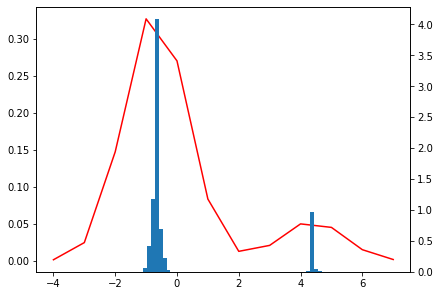

------------------------------------------------------------
File: /kaggle/input/mafaulda-machinery-fault-database/normal/32.9728.csv
Min: -2 Max: 7
Creating Kernel...
Kernel fitted!
Getting Probabilities...
Probabilities calculated!! [8.16793842e-14 1.63696830e-11 1.21892075e-09 3.44366410e-08
 3.97167642e-07 2.41521098e-06 1.41801968e-05 1.10840032e-04
 8.04538122e-04 4.34516917e-03 1.70477437e-02 5.30094422e-02
 1.39607509e-01 2.46007972e-01 2.27231674e-01 1.15151740e-01
 4.50200221e-02 1.64569807e-02 4.78384269e-03 1.02002481e-03
 1.83286536e-04 5.45086110e-05 4.17001761e-05 4.14050098e-05
 3.70145423e-05 3.35164597e-05 3.09032985e-05 2.77597142e-05
 2.68597289e-05 2.92167034e-05 2.97392262e-05 2.53511930e-05
 2.66654286e-05 3.49993568e-05 3.52388739e-05 2.67059124e-05
 2.12551604e-05 2.45495016e-05 2.76236983e-05 2.42195883e-05
 2.05852537e-05 2.25180846e-05 2.68879921e-05 2.94880459e-05
 3.21341449e-05 3.33114788e-05 3.02124665e-05 2.49162179e-05
 2.48208507e-05 2.80355486e-05 2.

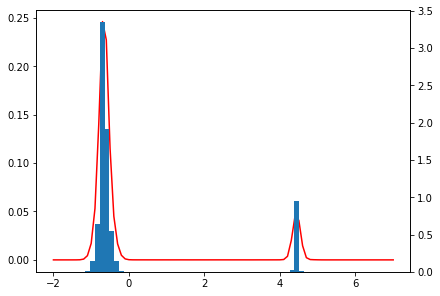

------------------------------------------------------------
File: /kaggle/input/mafaulda-machinery-fault-database/normal/32.9728.csv
Min: -2 Max: 7
Creating Kernel...
Kernel fitted!
Getting Probabilities...
Probabilities calculated!! [1.38594670e-03 2.29681314e-02 1.41772894e-01 3.25881594e-01
 2.79030196e-01 8.93000491e-02 1.34507823e-02 1.88404857e-02
 4.64861243e-02 4.36720791e-02 1.51485027e-02 1.93860589e-03
 9.15688252e-05]
[-4 -3 -2 -1  0  1  2  3  4  5  6  7  8]
Entropy is 1.7986302479509313 and total probability is 0.99996696030142


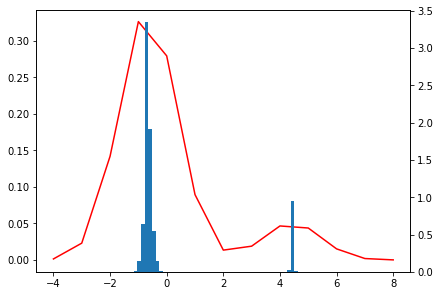

In [7]:
# 50 kHz sampling rate during 5 s
SAMPLE_RATE = 50000  # Hertz
DURATION = 5  # Seconds

samples = [0,5]
for sample in samples:
    filePath = normal_file_names[sample]
    data = data_raw[filePath]
    calculateEntropy(data[0], filePath, _debug = True, bandwidth = 0.1, mode = 'decimal')
    calculateEntropy(data[0], filePath, _debug = True, bandwidth = 1, mode = 'integer')

In [8]:
# 50 kHz sampling rate during 5 s
SAMPLE_RATE = 50000  #columnrtz
DURATION = 5  # Seconds

df_column_names = [columns_names[0] + ' main frequency', 'filePath']
metrics = ['mean', 'entropy' ,'kurtosis',
          'rms','peak to peak','shape indicator','impulse indicator','crest indicator','clearance indicator','skewness']

for column in columns_names:
    for m in metrics:
        df_column_names.append(column + ' ' + m)

In [9]:
report_step = 10
report_iter = 0

result = []
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()),'Start Processing Files...')


for filePath in all_files:
    if ((report_iter % report_step) == 0):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()),'Processing file number',report_iter,filePath)
    data = data_raw[filePath]
    freq = calculateMainFrequency(data[0],filePath)
    row = [freq,filePath]
    for column in data.columns:
        start = calculateMetricsAlzghoul(data[column],filePath)
        end = calculateMetricsDongyang(data[column],filePath)
        row.extend(start)
        row.extend(end)
    result.append(row)
    report_iter += 1

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()),'Finished processing files!!')
df = pd.DataFrame(columns=df_column_names, data = result)
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()),'DataSet Create!!')
df.to_csv('mycsvfile.csv')
df.head()

2021-07-29 11:24:12 Start Processing Files...
2021-07-29 11:24:12 Processing file number 0 /kaggle/input/mafaulda-machinery-fault-database/normal/45.4656.csv
2021-07-29 11:26:31 Processing file number 10 /kaggle/input/mafaulda-machinery-fault-database/normal/57.9584.csv
2021-07-29 11:28:51 Processing file number 20 /kaggle/input/mafaulda-machinery-fault-database/normal/20.2752.csv
2021-07-29 11:31:14 Processing file number 30 /kaggle/input/mafaulda-machinery-fault-database/normal/13.1072.csv
2021-07-29 11:33:38 Processing file number 40 /kaggle/input/mafaulda-machinery-fault-database/normal/19.6608.csv
2021-07-29 11:35:58 Processing file number 50 /kaggle/input/mafaulda-machinery-fault-database/imbalance/6g/53.6576.csv
2021-07-29 11:38:15 Processing file number 60 /kaggle/input/mafaulda-machinery-fault-database/imbalance/6g/31.5392.csv
2021-07-29 11:40:33 Processing file number 70 /kaggle/input/mafaulda-machinery-fault-database/imbalance/6g/46.6944.csv
2021-07-29 11:42:51 Processing fi

,Tachometer main frequency,filePath,Tachometer mean,Tachometer entropy,Tachometer kurtosis,Tachometer rms,Tachometer peak to peak,Tachometer shape indicator,Tachometer impulse indicator,Tachometer crest indicator,...,Microphone mean,Microphone entropy,Microphone kurtosis,Microphone rms,Microphone peak to peak,Microphone shape indicator,Microphone impulse indicator,Microphone crest indicator,Microphone clearance indicator,Microphone skewness
0,44.4,/kaggle/input/mafaulda-machinery-fault-databas...,0.000889,2.179218,2.470125,1.749317,-6.4459,1.460268,4.128913,2.827503,...,0.011329,2.209312,-0.340742,0.201635,-1.26886,1.203184,4.913227,4.083522,5.616851,0.476761
1,28.2,/kaggle/input/mafaulda-machinery-fault-databas...,-0.000823,2.162775,3.068834,1.690905,-6.3239,1.510413,4.466288,2.956997,...,0.013926,2.017096,-0.092222,0.155623,-1.06746,1.217336,5.625739,4.621351,6.463651,0.588356
2,36.6,/kaggle/input/mafaulda-machinery-fault-databas...,0.001785,2.167229,2.727691,1.723407,-6.4226,1.483517,4.273294,2.880516,...,0.012624,2.126806,-0.187329,0.181166,-1.19818,1.210490,5.303757,4.381495,6.079191,0.535767
3,55.4,/kaggle/input/mafaulda-machinery-fault-databas...,0.000350,2.184809,2.260206,1.771696,-6.4613,1.441018,3.987473,2.767123,...,0.011494,2.234220,-0.504289,0.208348,-1.28533,1.194746,4.679543,3.916768,5.332553,0.428885
4,15.8,/kaggle/input/mafaulda-machinery-fault-databas...,0.004700,2.162512,3.813742,1.625237,-6.3730,1.579440,4.958330,3.139296,...,0.014026,1.880101,-0.100899,0.125709,-0.83014,1.218678,5.577019,4.576287,6.405791,0.616928
